In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Load your sequential data of electricity demand
# Assuming your data is in a CSV file, with 'demand' column representing the electricity demand
data = pd.read_csv("./data/TCQ_DemandSum_DST.csv")

data['Target'] = data['Sum of DST']

# Subtract the average from the data
target_avg = data['Target'].mean()
target_avg = 0 # Hardcoded average demand, 0 means no subtraction
print("Average demand: ", target_avg)
data['Target'] = data['Target'] - target_avg

# Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
data['Target'] = scaler.fit_transform(data['Target'].values.reshape(-1,1))

# Function to create dataset with sequences of 48 demand values
def create_dataset(dataset, weeks=0, days=0, periods=48):
    look_back=periods + (days * 48) + (weeks * 7 * 48)
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

# Split data into training and testing sets
train_size = int(len(data) * 0.7)
validate_size = int(len(data) * 0.1)
test_size = len(data) - train_size - validate_size
train, validate, test = data.iloc[0:train_size], \
                        data.iloc[train_size:train_size+validate_size], \
                        data.iloc[train_size+validate_size:len(data)]

# Create datasets for training and testing
weeks = 0
days = 0
periods = 2
train_X, train_Y = create_dataset(train['Target'].values, weeks=weeks, days=days, periods=periods)
validate_X, validate_Y = create_dataset(validate['Target'].values, weeks=weeks, days=days, periods=periods)
test_X, test_Y = create_dataset(test['Target'].values, weeks=weeks, days=days, periods=periods)


Average demand:  0


In [24]:
train_X

array([[[-0.48208631],
        [-0.63875163]],

       [[-0.63875163],
        [-0.82160318]],

       [[-0.82160318],
        [-0.92891133]],

       ...,

       [[ 0.52568452],
        [ 0.45464221]],

       [[ 0.45464221],
        [ 0.34039289]],

       [[ 0.34039289],
        [ 0.25970713]]])

In [13]:
print(f"Next, reshape to {(train_X.shape[0], train_X.shape[1], 1)}")

Next, reshape to (8633, 2, 1)


In [14]:

# Reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))


## LSTM

In [15]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [16]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras.optimizers as optimizers

model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], 1), dropout=0.05))
model.add(Dense(4, activation='sigmoid'))
model.add(Dense(1))

optimizer = optimizers.get("Adam")
optimizer.learning_rate = 0.001

model.compile(optimizer=optimizer, loss='mse')
model.fit(train_X, train_Y, epochs=70, batch_size=32, verbose=0, validation_data=(validate_X, validate_Y))

In [17]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

In [18]:
loss_history = [model.history.history['loss'], model.history.history['val_loss']]
loss_history = pd.DataFrame(loss_history).T

loss        0.019689
val_loss    0.015722
Name: 69, dtype: float64


<Axes: >

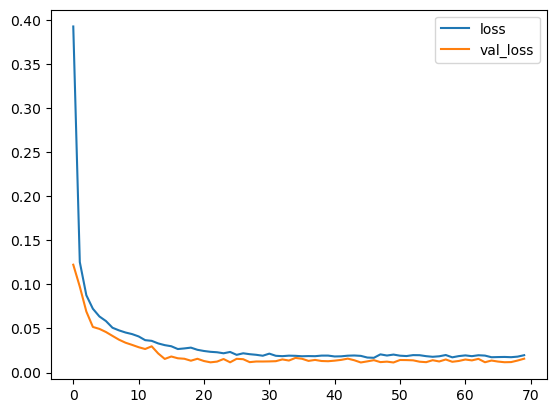

In [19]:
loss_history.columns = ['loss', 'val_loss']
print(loss_history.iloc[-1])

loss_history.plot()

## Predict & Evaluate

In [20]:
from sklearn.metrics import mean_squared_error

# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# Invert predictions to original scale
i_train_predict = scaler.inverse_transform(train_predict) + target_avg
i_train_Y = scaler.inverse_transform([train_Y]) + target_avg
i_test_predict = scaler.inverse_transform(test_predict) + target_avg
i_test_Y = scaler.inverse_transform([test_Y]) + target_avg


# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(i_train_Y[0], i_train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(i_test_Y[0], i_test_predict[:,0]))
print('Train RMSE:', train_score)
print('Test RMSE:', test_score)

78/78 [==============================] - 0s 3ms/step
Train RMSE: 54.22711977900188
Test RMSE: 67.54334748202874


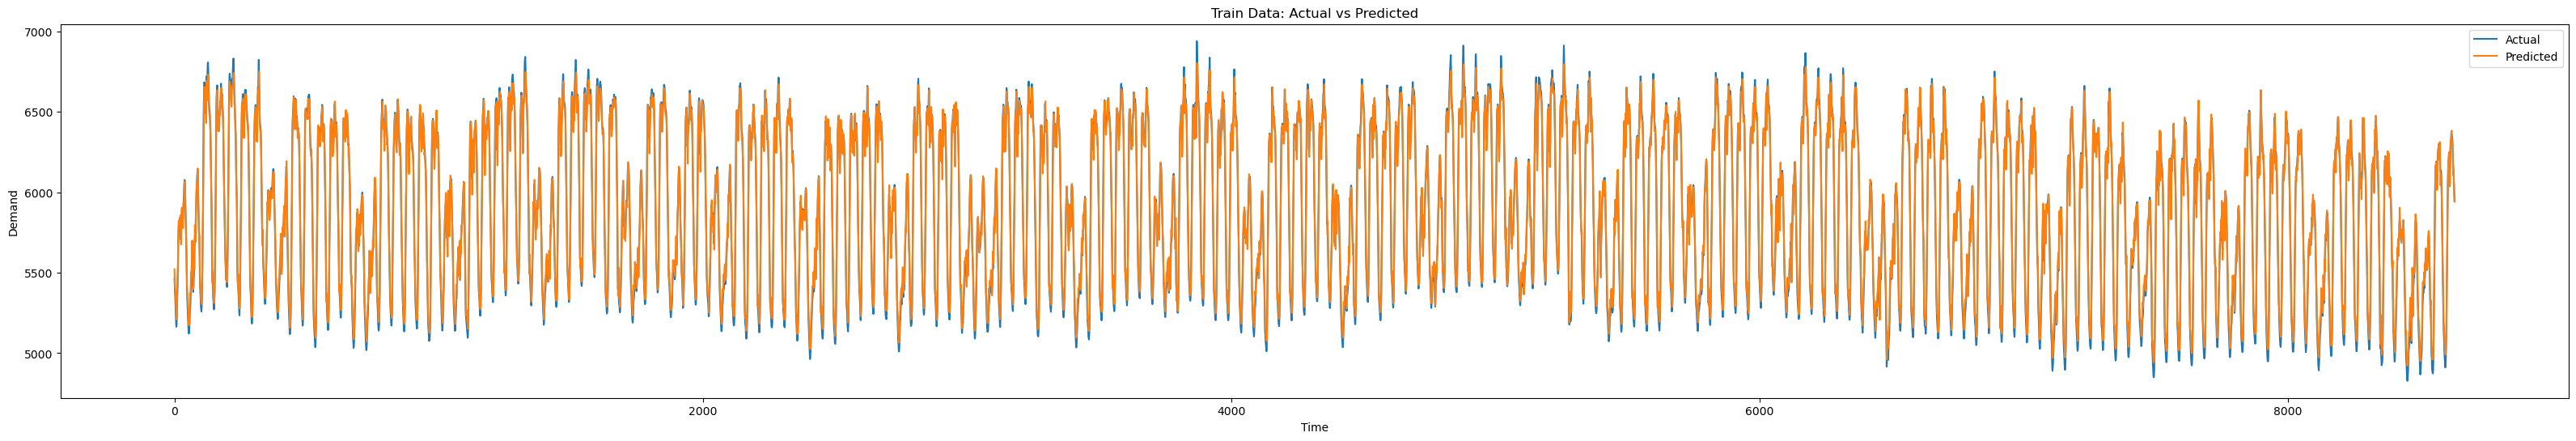

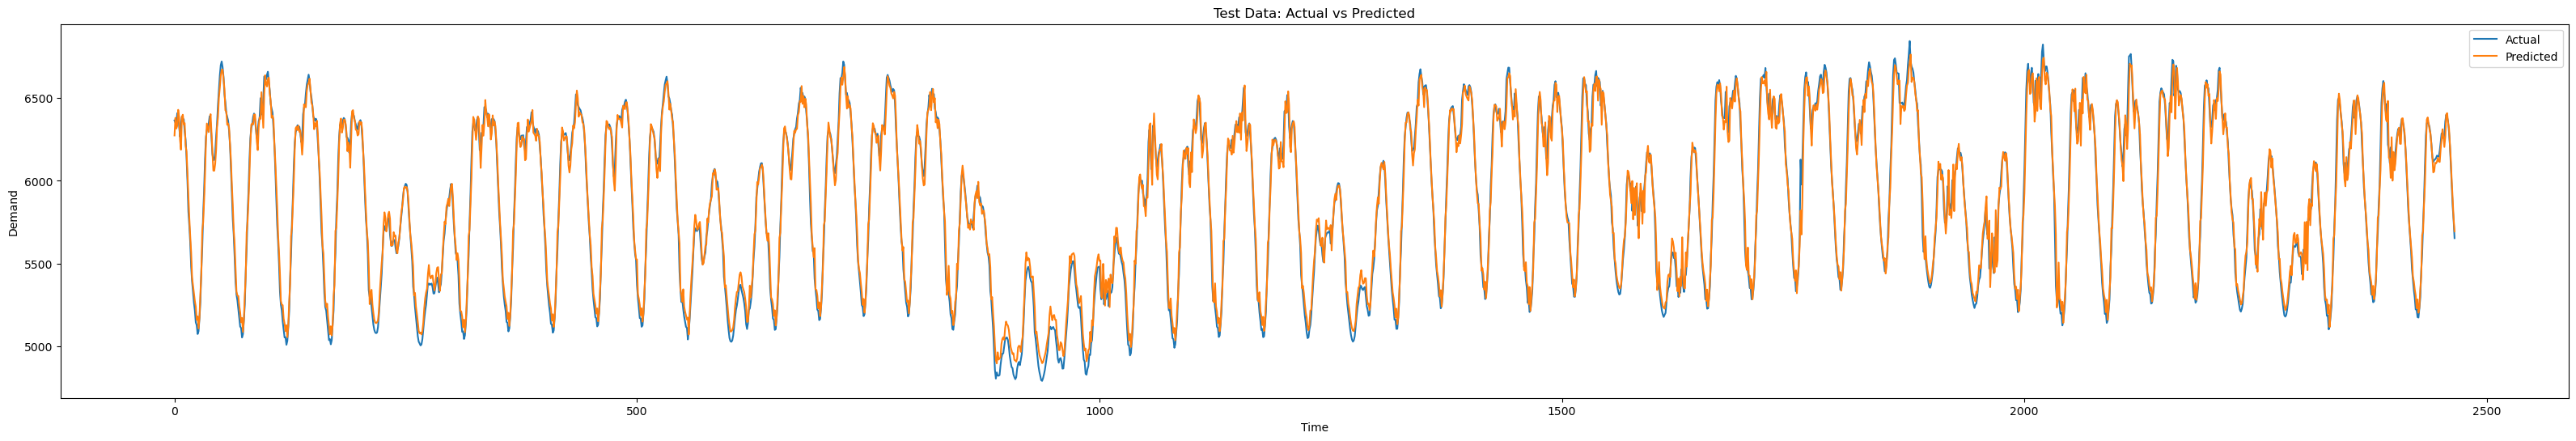

In [21]:
import matplotlib.pyplot as plt

# Plot train data
plt.figure(figsize=(40, 6))
plt.plot(i_train_Y[0], label='Actual')
plt.plot(i_train_predict[:, 0], label='Predicted')
plt.title('Train Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()

# Plot test data
plt.figure(figsize=(40, 6))
plt.plot(i_test_Y[0], label='Actual')
plt.plot(i_test_predict[:, 0], label='Predicted')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.show()


In [25]:
for i in range(50):
    print(f"test_Y[{i:03d}]: {i_test_Y[0][i]:.12f}, test_predict[{i:03d}]: {i_test_predict[i][0]:.12f}, diff: {abs(i_test_predict[i][0] - i_test_Y[0][i]):.12f}")

test_Y[000]: 6364.408184508997, test_predict[000]: 6273.444824218750, diff: 90.963360290247
test_Y[001]: 6349.689215178386, test_predict[001]: 6379.823242187500, diff: 30.134027009114
test_Y[002]: 6352.115702641472, test_predict[002]: 6315.169921875000, diff: 36.945780766472
test_Y[003]: 6408.203094427896, test_predict[003]: 6332.210449218750, diff: 75.992645209146
test_Y[004]: 6407.444087764469, test_predict[004]: 6428.235351562500, diff: 20.791263798031
test_Y[005]: 6330.096277697427, test_predict[005]: 6385.444335937500, diff: 55.348058240073
test_Y[006]: 6265.885763387839, test_predict[006]: 6246.384277343750, diff: 19.501486044089
test_Y[007]: 6345.287914963504, test_predict[007]: 6187.580566406250, diff: 157.707348557254
test_Y[008]: 6387.323829765261, test_predict[008]: 6385.366210937500, diff: 1.957618827761
test_Y[009]: 6373.149341233744, test_predict[009]: 6398.792968750000, diff: 25.643627516256
test_Y[010]: 6371.219562940588, test_predict[010]: 6339.798339843750, diff: 31.4